# Week 2: Looking at Some Data

---

## Overview

Some guidance on what to take a look at:

* Consider what questions we want to ask from our evolutionary tree analysis. Think about what questions the book was trying to answer. Do we even have the data in this notebook to answer some of those questions? If not, spend time trying to find it now that you can know more about what to look for in terms of format. Do some literature searching and see what other work has been done for this virus and others.
* Research and try different evolutionary tree programs/frameworks. What I've done below is not the only game in town by far. Biopython itself has different options.
* Consider the alignment itself. Are there different ways to do this? Did we do it correctly?
* What about the sequences themselves? Are they all of the same quality? Should we exclude some?
* What about the virus alignment program? Did we use that correctly? Should we have done the entire sequence instead of using Spike as a reference? Should we try a different reference.
* Do we have more data available about the sequences? Part of world, etc. Can we do some digging here to answer different questions.
* And I'm sure you can think of more to attempt... Think about what you want to do. Spend time working towards a well thoughtout goal. Document things as you go. Talk to everyone on Slack. Together we can do this!

---

## Getting some Initial Data

In [2]:
import wget

url = 'https://covid19.galaxyproject.org/genomics/4-Variation/current_complete_ncov_genomes.fasta'
file = 'data/current_complete_ncov_genomes.fasta'
wget.download(url, file)

'data/current_complete_ncov_genomes.fasta'

Getting an alignment (sequence MT350234.1 had an error):

In [1]:
!virulign ../../virulign/references/SARS-CoV-2/S.xml data/current_complete_ncov_genomes.fasta --exportAlphabet Nucleotides --exportKind PositionTable > data/position_table.csv

---

## Some Initial Work

### Read the Data into a pandas DataFrame

In [3]:
import pandas as pd
position_table = pd.read_csv('data/position_table.csv')
results = position_table.describe()
display(position_table)
display(results)

,seqid,S_1_1,S_1_2,S_1_3,S_2_1,S_2_2,S_2_3,S_3_1,S_3_2,S_3_3,S_4_1,S_4_2,S_4_3,S_5_1,S_5_2,S_5_3,S_6_1,S_6_2,S_6_3,S_7_1,S_7_2,S_7_3,S_8_1,S_8_2,S_8_3,S_9_1,S_9_2,S_9_3,S_10_1,S_10_2,S_10_3,S_11_1,S_11_2,S_11_3,S_12_1,S_12_2,S_12_3,S_13_1,S_13_2,S_13_3,...,S_1260_3,S_1261_1,S_1261_2,S_1261_3,S_1262_1,S_1262_2,S_1262_3,S_1263_1,S_1263_2,S_1263_3,S_1264_1,S_1264_2,S_1264_3,S_1265_1,S_1265_2,S_1265_3,S_1266_1,S_1266_2,S_1266_3,S_1267_1,S_1267_2,S_1267_3,S_1268_1,S_1268_2,S_1268_3,S_1269_1,S_1269_2,S_1269_3,S_1270_1,S_1270_2,S_1270_3,S_1271_1,S_1271_2,S_1271_3,S_1272_1,S_1272_2,S_1272_3,S_1273_1,S_1273_2,S_1273_3
0,MT007544.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
1,MT019529.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
2,MT019530.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
3,MT019531.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
4,MT019532.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,MT350277.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
816,MT350278.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
817,MT350279.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
818,MT350280.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A


,seqid,S_1_1,S_1_2,S_1_3,S_2_1,S_2_2,S_2_3,S_3_1,S_3_2,S_3_3,S_4_1,S_4_2,S_4_3,S_5_1,S_5_2,S_5_3,S_6_1,S_6_2,S_6_3,S_7_1,S_7_2,S_7_3,S_8_1,S_8_2,S_8_3,S_9_1,S_9_2,S_9_3,S_10_1,S_10_2,S_10_3,S_11_1,S_11_2,S_11_3,S_12_1,S_12_2,S_12_3,S_13_1,S_13_2,S_13_3,...,S_1260_3,S_1261_1,S_1261_2,S_1261_3,S_1262_1,S_1262_2,S_1262_3,S_1263_1,S_1263_2,S_1263_3,S_1264_1,S_1264_2,S_1264_3,S_1265_1,S_1265_2,S_1265_3,S_1266_1,S_1266_2,S_1266_3,S_1267_1,S_1267_2,S_1267_3,S_1268_1,S_1268_2,S_1268_3,S_1269_1,S_1269_2,S_1269_3,S_1270_1,S_1270_2,S_1270_3,S_1271_1,S_1271_2,S_1271_3,S_1272_1,S_1272_2,S_1272_3,S_1273_1,S_1273_2,S_1273_3
count,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,...,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820
unique,820,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,MT326140.1,A,T,G,T,T,T,G,T,T,T,T,T,C,T,T,G,T,T,T,T,A,T,T,G,C,C,A,C,T,A,G,T,C,T,C,T,A,G,T,...,C,T,C,T,G,A,G,C,C,A,G,T,G,C,T,C,A,A,A,G,G,A,G,T,C,A,A,A,T,T,A,C,A,T,T,A,C,A,C,A
freq,1,820,820,820,820,820,820,820,820,820,820,820,820,814,820,820,820,820,820,820,820,820,820,820,820,820,819,820,820,820,820,820,820,819,820,820,820,820,820,820,...,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820,820


### Pull Out the Concensus Sequence

Concensus Sequence
: a sequence of DNA having similar structure and function in different organisms.

In [4]:
concensus_seq = position_table.drop('seqid',axis=1).mode(axis=0).T[0]
display(concensus_seq)
position_table.set_index('seqid',inplace=True)

S_1_1       A
S_1_2       T
S_1_3       G
S_2_1       T
S_2_2       T
           ..
S_1272_2    A
S_1272_3    C
S_1273_1    A
S_1273_2    C
S_1273_3    A
Name: 0, Length: 3819, dtype: object

---

## Utilizing Biopython for Initial Analysis

Determine which samples are farthest from the concensus sequence

In [5]:
distance_from_concensus_seq = position_table.apply(lambda row: sum(row != concensus_seq),axis=1)
distance_from_concensus_seq_sorted = distance_from_concensus_seq.sort_values(ascending=False)
display(distance_from_concensus_seq_sorted)

seqid
MT345850.1    263
MT345852.1    141
MT345843.1    122
MT345884.1     97
MT233522.1     82
             ... 
MT263449.1      0
MT263451.1      0
MT263452.1      0
MT263454.1      0
MT263422.1      0
Length: 820, dtype: int64

Select 10 sequences to do our first analysis

In [6]:
subset_seqs = distance_from_concensus_seq_sorted[:10].index
display(subset_seqs)

Index(['MT345850.1', 'MT345852.1', 'MT345843.1', 'MT345884.1', 'MT233522.1',
       'MT308696.1', 'MT308694.1', 'MT263453.1', 'MT259284.1', 'MT293180.1'],
      dtype='object', name='seqid')

Construct a distance matrix for the sequences

In [7]:
distances = {}
for i,seqid1 in enumerate(subset_seqs):
    distances[seqid1,seqid1] = 0
    for j in range(i+1,len(subset_seqs)):
        seqid2 = subset_seqs[j]
        distances[seqid1,seqid2] = sum(position_table.loc[seqid1] != position_table.loc[seqid2])
        distances[seqid2,seqid1] = distances[seqid1,seqid2]
distances = pd.Series(distances).unstack()
display(distances)

,MT233522.1,MT259284.1,MT263453.1,MT293180.1,MT308694.1,MT308696.1,MT345843.1,MT345850.1,MT345852.1,MT345884.1
MT233522.1,0,115,130,104,135,151,202,345,221,177
MT259284.1,115,0,81,47,86,104,107,230,108,94
MT263453.1,130,81,0,68,101,119,134,299,189,143
MT293180.1,104,47,68,0,77,93,130,273,153,89
MT308694.1,135,86,101,77,0,22,175,286,194,150
MT308696.1,151,104,119,93,22,0,191,288,210,166
MT345843.1,202,107,134,130,175,191,0,211,77,115
MT345850.1,345,230,299,273,286,288,211,0,164,276
MT345852.1,221,108,189,153,194,210,77,164,0,136
MT345884.1,177,94,143,89,150,166,115,276,136,0


Constructing the Distance Matrix

In [9]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
import numpy as np
matrix = np.tril(distances.values).tolist()
for i in range(len(matrix)):
    matrix[i] = matrix[i][:i+1]
dm = DistanceMatrix(list(distances.index),matrix)

Now construct the tree

In [10]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

Drawing the tree

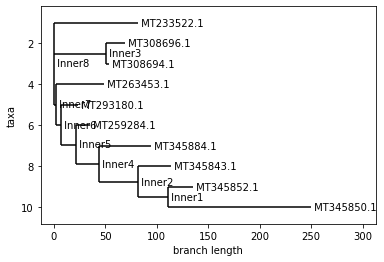

In [11]:
%matplotlib inline

from Bio import Phylo
tree.ladderize() # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

---

